# WeatherPy


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from ratelimit import limits
import time
import json
import seaborn as sns
import logging
from datetime import date

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

613

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).

> **HINT:** The OpenWeatherMap API only allows 60 calls per minute under their free plan. Try using `time.sleep(60)` after each set of 50 cities to avoid API errors due to large calls.

In [3]:
# Setup API Calling
# url
url = "http://api.openweathermap.org/data/2.5/weather?"
# url = "https://openweathermap.org/api"

# units
unit = "units=Imperial"

# api
api = "&APPID=" + weather_api_key

# response 
response = requests.get( url + unit + api).json()

# print statement
print(response)


# Storage for api call data
city_info = {"City": [], 
             "Lat": [], 
             "Lng": [],
             "Max Temp": [],
             "Humidity": [],
             "Cloudiness": [],
             "Wind Speed": [],
             "Country": [], 
             "Date": []}

# hint, limit api calls
minute = 60
@limits(calls=60, period=minute)

# api call loop
def call_api():
    
    for i, city in enumerate(cities):
        city = requests.get(url + unit + "&q=" + cities[i] + api).json()
        
        try:
            print("Processing city " + str(i) + ": " + city["name"])
        
            city_info["City"].append(city["name"])
            city_info["Lat"].append(city["coord"]["lat"])
            city_info["Lng"].append(city["coord"]["lon"])
            city_info["Max Temp"].append(city["main"]["temp_max"])
            city_info["Humidity"].append(city["main"]["humidity"])
            city_info["Cloudiness"].append(city["clouds"]["all"])
            city_info["Wind Speed"].append(city["wind"]["speed"])
            city_info["Country"].append(city["sys"]["country"])
            city_info["Date"].append(city["dt"])
            
        except:
            print("Incomplete..., skip over missing city info.")
            pass
    print("Complete")
    
call_api()

# print log
logging.basicConfig(filename='api_print.log', filemode='w')
logging.warning('This data will be logged onto a file')


            
            
        

{'cod': '400', 'message': 'Nothing to geocode'}
Processing city 0: Daru
Processing city 1: Hobart
Processing city 2: Panabá
Processing city 3: Hermanus
Processing city 4: Port Alfred
Processing city 5: Mataura
Processing city 6: East London
Processing city 7: Hegang
Processing city 8: George Town
Processing city 9: Madimba
Processing city 10: Salalah
Processing city 11: Atuona
Processing city 12: Jamestown
Processing city 13: Dikson
Processing city 14: Kalmar
Processing city 15: Castro
Processing city 16: Bambous Virieux
Incomplete..., skip over missing city info.
Processing city 18: Bariloche
Processing city 19: Røros
Processing city 20: Kaitangata
Processing city 21: Ushuaia
Processing city 22: Waipawa
Processing city 23: Zvolen
Processing city 24: Severo-Kuril'sk
Processing city 25: Chokurdakh
Incomplete..., skip over missing city info.
Processing city 27: Mahébourg
Processing city 28: Yellowknife
Processing city 29: Tiarei
Processing city 30: Ibrā’
Processing city 31: Shubarshi
Pro

Processing city 263: Catherinas Lust
Incomplete..., skip over missing city info.
Processing city 265: Lodja
Incomplete..., skip over missing city info.
Processing city 267: Santa Rosa
Processing city 268: Mackay
Processing city 269: Castel San Pietro Terme
Processing city 270: Borogontsy
Processing city 271: Haines Junction
Processing city 272: Maningrida
Processing city 273: Katsuura
Processing city 274: Cayenne
Processing city 275: Kavieng
Processing city 276: Thinadhoo
Processing city 277: Tooele
Processing city 278: Broome
Processing city 279: Mar del Plata
Processing city 280: Caravelas
Incomplete..., skip over missing city info.
Processing city 282: Ashibetsu
Processing city 283: Lima
Processing city 284: Lensk
Processing city 285: Pevek
Incomplete..., skip over missing city info.
Incomplete..., skip over missing city info.
Processing city 288: Tasiilaq
Processing city 289: Owosso
Processing city 290: Vila Velha
Processing city 291: North Las Vegas
Processing city 292: Deer Lake


Processing city 524: Verkhnevilyuysk
Processing city 525: Chui
Processing city 526: Suratgarh
Processing city 527: Malinovoye Ozero
Processing city 528: Sumenep
Processing city 529: Port Lincoln
Processing city 530: Oksovskiy
Processing city 531: Takoradze
Processing city 532: Manono
Processing city 533: Tecpan
Processing city 534: Diego de Almagro
Processing city 535: Jiangyou
Incomplete..., skip over missing city info.
Processing city 537: Hay River
Processing city 538: Puerto Limón
Processing city 539: Saldanha
Processing city 540: Nelson Bay
Processing city 541: Leh
Processing city 542: Ucluelet
Processing city 543: Chālūs
Processing city 544: Meïganga
Processing city 545: Abu Samrah
Processing city 546: Necochea
Processing city 547: Umaria
Processing city 548: Broken Hill
Processing city 549: Gusinoye Ozero
Processing city 550: Imperatriz
Processing city 551: Te Anau
Processing city 552: Ugoofaaru
Processing city 553: Andenes
Processing city 554: Kondoa
Processing city 555: Mahaja

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
# Creating DataFrame
city_info_df = pd.DataFrame(city_info)

# Clean DataFrame
city_info_df["Max Temp"] = city_info_df["Max Temp"].replace('', np.nan)
city_info_df = city_info_df.dropna()

city_count = len(city_info_df)
# Export as CSV file
city_info_df.to_csv(output_data_file, index_label="City_ID")

In [5]:
# Inspect DataFrame
city_info_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Daru,-9.0763,143.2092,83.88,75,100,6.58,PG,1644453525
1,Hobart,-42.8794,147.3294,73.02,44,40,14.97,AU,1644452936
2,Panabá,21.2833,-88.2667,66.94,89,8,6.22,MX,1644453526
3,Hermanus,-34.4187,19.2345,67.89,88,99,2.46,ZA,1644453217
4,Port Alfred,-33.5906,26.8910,65.10,86,2,9.26,ZA,1644453193
...,...,...,...,...,...,...,...,...,...
561,Gillette,44.2911,-105.5022,41.92,64,75,23.02,US,1644453629
562,Bouna,9.2667,-3.0000,74.16,18,3,4.54,CI,1644453630
563,Noyabrsk,63.1994,75.4507,-10.59,92,12,11.32,RU,1644453630
564,Serenje,-13.2325,30.2352,62.37,99,100,2.53,ZM,1644453630


In [6]:
leftover_cities = city_info_df.loc[city_info_df["City"] != "Failed!"]
leftover_cities_count = len(leftover_cities)
print("{} number of cities were left out of the {} cities accounted for, giving a success rate of {:.1%} retrieval."
      .format(leftover_cities_count, city_count, (leftover_cities_count/city_count)))

leftover_cities.index = [a for a in range(leftover_cities_count)]

non_numeric_columns = ["City", "Country", "Date"]

for col in leftover_cities.columns:
    if(col not in non_numeric_columns):
        leftover_cities[col] = pd.to_numeric(leftover_cities[col])
        

leftover_cities

566 number of cities were left out of the 566 cities accounted for, giving a success rate of 100.0% retrieval.


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Daru,-9.0763,143.2092,83.88,75,100,6.58,PG,1644453525
1,Hobart,-42.8794,147.3294,73.02,44,40,14.97,AU,1644452936
2,Panabá,21.2833,-88.2667,66.94,89,8,6.22,MX,1644453526
3,Hermanus,-34.4187,19.2345,67.89,88,99,2.46,ZA,1644453217
4,Port Alfred,-33.5906,26.8910,65.10,86,2,9.26,ZA,1644453193
...,...,...,...,...,...,...,...,...,...
561,Gillette,44.2911,-105.5022,41.92,64,75,23.02,US,1644453629
562,Bouna,9.2667,-3.0000,74.16,18,3,4.54,CI,1644453630
563,Noyabrsk,63.1994,75.4507,-10.59,92,12,11.32,RU,1644453630
564,Serenje,-13.2325,30.2352,62.37,99,100,2.53,ZM,1644453630


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
# Table Columns
lat = city_info_df["Lat"]
max_temp = city_info_df["Max Temp"]
humidity = city_info_df["Humidity"]
cloudiness = city_info_df["Cloudiness"]
wind_speed = city_info_df["Wind Speed"]

In [8]:
#  Get the indices of cities that have humidity over 100%.
city_info_df["Humidity"]

0      75
1      44
2      89
3      88
4      86
       ..
561    64
562    18
563    92
564    99
565    96
Name: Humidity, Length: 566, dtype: int64

C:\Users\chris\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Humidity'>

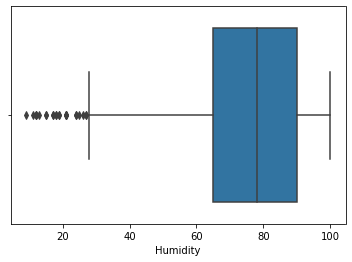

In [9]:
# Couldn't figure out how to use plot_filtered to fix FutureWarning
sns.boxplot(city_info_df["Humidity"])



In [10]:
# Print Outlier (if one exists)
print(np.where(city_info_df["Humidity"] > 100))
# Array is empty, no 'Humidity' over 100% exists in current dataset.

(array([], dtype=int64),)


#### Are There Any Cities With Humidity Over 100 % ?
From the results of the boxplot and the conditional print statement, there does not seem to be any cities within the dataset that has a humidity of over 100%.  

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Temperature vs Latitude Scatter Plot

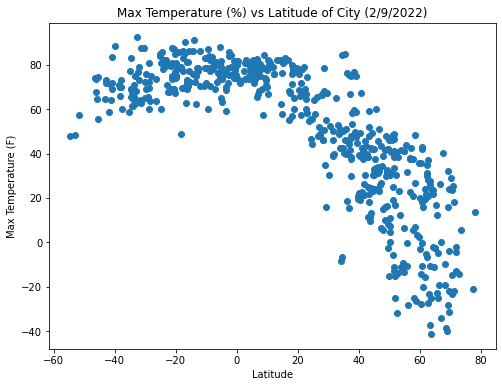

In [11]:
# Latitude vs Temperature
# viz config
plt.figure(figsize=(8,6))
lat_vs_temp = plt.scatter(lat, max_temp, linewidths=1, marker="o")

# titles & labels
plt.title("Max Temperature (%) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
# Display Plot
plt.show()

#### Temperature vs. Latitude Scatter Plot Analysis¶
The above scatter plot analyzies the latitudes of cities (north or south) of the equator against their correponding maximum temperatures (in degrees fahrenheit). Temperatures rise the closer a city is in relation to the equator. Cities south of the equator have higher maximum temperatures in comparison to cities north of the equator.  

In [12]:
# Save fig
lat_vs_temp.get_figure().savefig("../Images/Fig1.png")

## Humidity vs. Latitude Scatter Plot

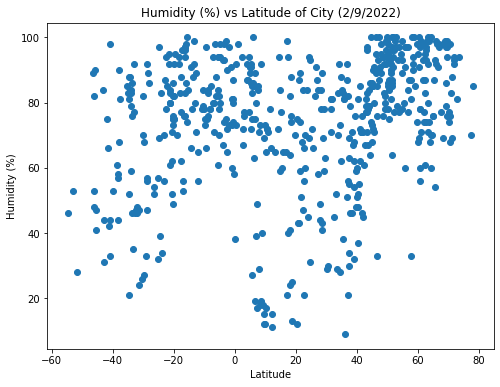

In [13]:
# Latitude vs Humidity
# viz config
plt.figure(figsize=(8,6))
lat_vs_humidity = plt.scatter(lat, humidity, linewidths=1, marker="o")

# titles & labels
plt.title("Humidity (%) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
# Display Plot
plt.show()

#### Humidity vs. Latitude Scatter Plot Analysis

The above scatter plot analyzies percent humidity against the latitudinal of a city in relation to the equator. There seems to be no apparently noticeable relationship between humidity and geolocation. 

In [14]:
lat_vs_humidity.get_figure().savefig("../Images/Fig2.png")

## Cloudiness vs. Latitude Scatter Plot

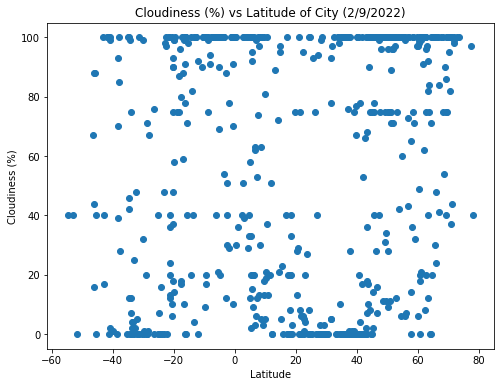

In [15]:
# Cloudiness vs. Latitude Scatter Plot
# viz config
plt.figure(figsize=(8,6))
lat_vs_cloudiness = plt.scatter(lat, cloudiness, linewidths=1, marker="o")

# titles & labels
plt.title("Cloudiness (%) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
# Display Plot
plt.show()

The scatter plot of Cloudiness vs. Latitude does does not show any associations between cloud cover and latitudial location.    

In [16]:
lat_vs_cloudiness.get_figure().savefig("../Images/Fig3.png")

## Wind Speed vs Latitude Scatter Plot

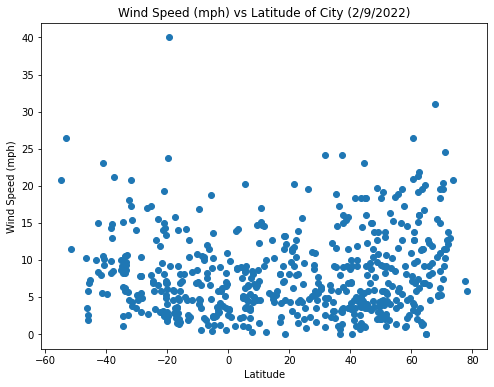

In [17]:
# Wind Speed vs Latitude Scatter Plot
# viz config
plt.figure(figsize=(8,6))
lat_vs_wind_speed = plt.scatter(lat, wind_speed, linewidths=1, marker="o")

# titles & labels
plt.title("Wind Speed (mph) vs Latitude of City (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
# Display Plot
plt.show()

#### Wind Speed vs Latitude Scatter Plot Analysis
The Wind Speed vs Latitude Scatter Plot shows no apparent associations between wind speed and geolocation for cities north or south of the equator.

In [18]:
lat_vs_wind_speed.get_figure().savefig("../Images/Fig4.png")

## Linear Regression

In [19]:
# Linear Regression
def makeLinRegression(city_info_df, x_Col, y_Col):
    # preform linear regression
    (regr_slope, regr_intercept, regr_r_val, _, _) = linregress(city_info_df[x_Col], city_info_df[y_Col])
    # setup x and y axis data for linear regression 
    x = np.array([a for a in range(int(min(city_info_df[x_Col].values)), int(max(city_info_df[x_Col].values)+1))])
    y = regr_slope * x + regr_intercept
    # scatter plot
    axis_df = city_info_df.plot(kind="scatter", x=x_Col, y=y_Col, title="{} vs {} ({})")
    # best fit line
    axis_df.plot(x, y, 'r')
    
    # print statements
    print("Equation for best-fit linear regression line is y={:.2f}x+{:.2f}".format(regr_slope, regr_intercept))
    
    print("r-squared correlation coefficient is {:.2f}".format(regr_r_val))
    
    # return statement
    return axis_df

In [20]:
# Northern and Southern Hemispheres

# Northern Hemisphere DataFrame
northern_hemisphere = city_info_df.loc[city_info_df["Lat"] >= 0]
# Count of Cities in the Northern Hemisphere
northern_count = len(northern_hemisphere)
# Print 
print("The northern hemisphere has {} cities out of {} total, accounting for {:.1%} of cities in the dataset."
      .format(northern_count, city_count, (northern_count/city_count)))

# Southern Hemisphere DataFrame
southern_hemisphere = city_info_df.loc[city_info_df["Lat"] < 0]
# Count of Cities in the Southern Hemisphere
southern_count = len(southern_hemisphere)
# Print 
print("The southern hemisphere has {} cities out of {} total, accounting for {:.1%} of cities in the dataset."
      .format(southern_count, city_count, (southern_count/city_count)))

The northern hemisphere has 377 cities out of 566 total, accounting for 66.6% of cities in the dataset.
The southern hemisphere has 189 cities out of 566 total, accounting for 33.4% of cities in the dataset.


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

Line of Best-Fit for linear regression is y=-1.30x+89.29
The r-squared correlation coefficient is -0.83


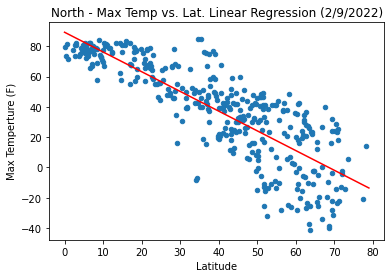

<Figure size 576x432 with 0 Axes>

In [36]:
(n_temp_slope, n_temp_intercept, n_temp_r_val, _, _) = linregress(northern_hemisphere["Lat"],
                                                                 northern_hemisphere["Max Temp"])

x = np.array([a for a in range(80)])
y = n_temp_slope * x + n_temp_intercept

n_temp_axes = northern_hemisphere.plot(kind="scatter", x="Lat", y="Max Temp",
                                       title="North - Max Temp vs. Lat. Linear Regression (2/9/2022)")
# line of best fit
n_temp_axes.plot(x, y, 'r')

plt.xlabel("Latitude")
plt.ylabel("Max Temperture (F)")
plt.figure(figsize=(8,6))

# print 
print("Line of Best-Fit for linear regression is y={:.2f}x+{:.2f}"
      .format(n_temp_slope, n_temp_intercept))
print("The r-squared correlation coefficient is {:.2f}".format(n_temp_r_val))

# save figure as png
n_temp_axes.get_figure().savefig("../Images/Fig5_N.png")

#### Northern Hemisphere - Max Temp vs. Latitude Linear Regression Analysis

According to the linear regression of maximum temperature vs latitude for the cities in the northern hemisphere, there is a strong negative correlation. The farther away a city's geolocation is to the equator the colder the climate conditions.  

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.25x+79.44
r-squared correlation coefficient is 0.40


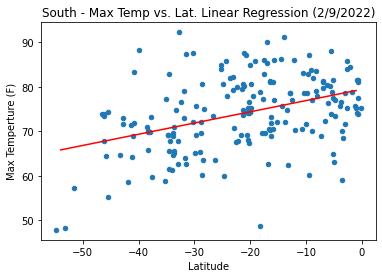

<Figure size 576x432 with 0 Axes>

In [37]:
s_temp_axes = makeLinRegression(southern_hemisphere, "Lat", "Max Temp")
plt.title("South - Max Temp vs. Lat. Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Max Temperture (F)")
plt.figure(figsize=(8,6))
# save figure as png
s_temp_axes.get_figure().savefig("../Images/Fig6_S.png")

#### Southern Hemisphere - Max Temp vs. Latitude Linear Regression Analysis

The above linear regression shows a positive relationship between geolocation of cities in the southern hemisphere relative to the equator and their cooresopnding climate conditions. The cities closer to the equator enjoy warmer climate conditions and therefore higher maximum temperatures. 

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.42x+57.90
r-squared correlation coefficient is 0.39


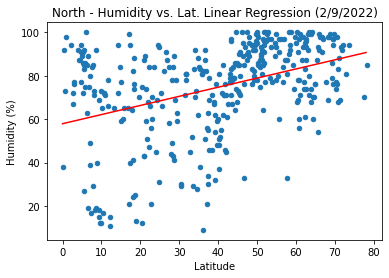

<Figure size 576x432 with 0 Axes>

In [38]:
# Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression
n_humidity_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Humidity")
plt.title("North - Humidity vs. Lat. Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.figure(figsize=(8,6))
# save figure as png
n_humidity_lat_axes.get_figure().savefig("../Images/Fig7_N.png")

#### Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression Analysis 
Dispite the somewhat positive correlation coefficient for the linear regression of Humidity (%) vs. Latitude for cities in the northern hemisphere, the outliers throughout makes the results for this particular dataset skewed. There should not be any noticable correlation between humidity for cities in respect to their geolocation from the equator. 

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.63x+86.45
r-squared correlation coefficient is 0.45


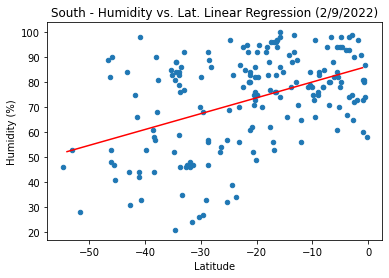

<Figure size 576x432 with 0 Axes>

In [39]:
# Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression
s_humidity_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Humidity")
plt.title("South - Humidity vs. Lat. Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.figure(figsize=(8,6))
# save figure as png
s_humidity_lat_axes.get_figure().savefig("../Images/Fig8_S.png")

#### Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression Analysis 
Likewise there should be little to no assoication between humidity and geolocation for cities in the southern hemisphere. 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.61x+31.18
r-squared correlation coefficient is 0.30


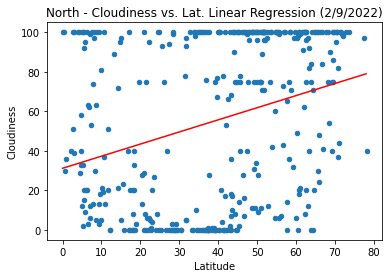

<Figure size 576x432 with 0 Axes>

In [40]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
n_cloudiness_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Cloudiness")
plt.title("North - Cloudiness vs. Lat. Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.figure(figsize=(8,6))
# save figure as png
n_cloudiness_lat_axes.get_figure().savefig("../Images/Fig9_N.png")

#### Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression Analysis

Judging from the overall data spread, there should be little to no correlation between cloud coverage and geolocation for cities in the northern hemisphere. 

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=1.13x+80.22
r-squared correlation coefficient is 0.37


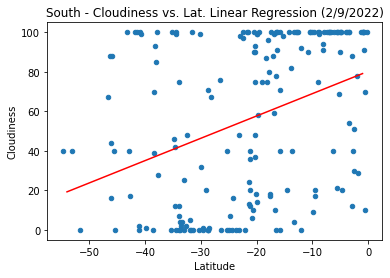

<Figure size 576x432 with 0 Axes>

In [41]:
# Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
s_cloudiness_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Cloudiness")
plt.title("South - Cloudiness vs. Lat. Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.figure(figsize=(8,6))
# save figure as png
s_cloudiness_lat_axes.get_figure().savefig("../Images/Fig10_S.png")

#### Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression Analysis

Similarly, there should also be little to no correlation between cloud coverage and geolocation for cities in the southern hemisphere. 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=0.06x+5.68
r-squared correlation coefficient is 0.22


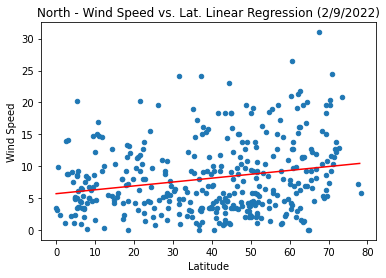

<Figure size 576x432 with 0 Axes>

In [42]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
n_wind_lat_axes = makeLinRegression(northern_hemisphere, "Lat", "Wind Speed")
plt.title("North - Wind Speed vs. Lat. Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.figure(figsize=(8,6))
# save figure as png
n_wind_lat_axes.get_figure().savefig("../Images/Fig11_N.png")

According to the the correlation coefficient for the linear regression for Wind Speed (mph) vs. Latitude, there should be almost no or slightly weak positive correlation between wind speed and geolocation away from the equator. This data could be skewed by the outliers for a few very windy northern cities. 

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Equation for best-fit linear regression line is y=-0.12x+5.21
r-squared correlation coefficient is -0.29


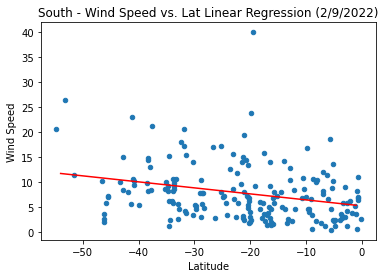

<Figure size 576x432 with 0 Axes>

In [43]:
# Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
s_wind_lat_axes = makeLinRegression(southern_hemisphere, "Lat", "Wind Speed")
plt.title("South - Wind Speed vs. Lat Linear Regression (2/9/2022)")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.figure(figsize=(8,6))
# save figure as png
s_wind_lat_axes.get_figure().savefig("../Images/Fig12_S.png")

#### Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression Analysis

Reasonably should also not be any association between wind speed and geolocation away from the equator for cities in the southern hemisphere.  

In [44]:
# outliers for observations 
print(np.where(city_info_df["Wind Speed"] > 30))

(array([298, 511], dtype=int64),)


In [45]:
print(city_info_df.iloc[[44,  96, 548]])
# Outliers: Sørland (67.6670, 32.26), Isangel (40.18, -19.5500), Vao (-22.6667, 30.29) 

          City      Lat       Lng  Max Temp  Humidity  Cloudiness  Wind Speed  \
44     Isabela   6.7085  121.9711     82.45        75          62        3.38   
96   Porbandar  21.6422   69.6093     67.35        51           6       11.79   
548   Araouane  18.9048   -3.5265     64.81        13           3       12.12   

    Country        Date  
44       PH  1644453531  
96       IN  1644453397  
548      ML  1644453627  
